<img src="images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib time series data and quasi vertical profiles

---

## Overview

Within this notebook, we will cover:

1. Reading radar sweep timeseries data into xarray based RadarVolume
1. Examination of RadarVolume and Sweep
1. Calculation of Quasivertical Profiles and Plotting

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Xarray Plotting](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Plotting/Faceting |

- **Time to learn**: 7.5 minutes

---

## Imports

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import os
from tqdm import tqdm_notebook as tqdm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Get hold of some  some Australien Radar Data

It is assumed, that data from IDR71 (Sidney) from 20th of December 2018 is used in this notebook.

In [2]:
fglob = 'data/wradlib/hdf5/terry_*.h5'
idr71 = glob.glob(fglob)
idr71.sort()
print("Files available: {}".format(len(idr71)))

Files available: 40


## Open ODIM_H5 Volume


In [3]:
odh = wrl.io.open_odim_dataset(idr71[24])

In [4]:
display(odh)

<wradlib.RadarVolume>
Dimension(s): (sweep: 1)
Elevation(s): (32.0)

## Quasi Vertical Profile (QVP)

This example shows how to create a so called QVP. We need to define a function to add a height coordinate for plotting.

In [5]:
def add_height(ds):
    ds = ds.pipe(wrl.georef.georeference_dataset)
    height = ds.z.mean('azimuth')
    ds = ds.assign_coords({'height': (['range'], height.data)})
    return ds

### Single Profile

Here we add the height coordinate and calculate the `mean` over the azimuth using the sweep with the highest available elevation.

In [6]:
swp = odh[0].pipe(add_height)
qvp = swp.mean('azimuth')
qvp

<xarray.Dataset>
Dimensions:     (range: 200)
Coordinates:
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    time        datetime64[ns] 2018-12-20T07:28:37
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 151.2
    latitude    float64 -33.7
    altitude    float64 195.0
    height      (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH        (range) float32 1.143 -1.34 4.022 6.988 ... nan nan nan nan
    VRADH       (range) float32 -3.843 -2.17 -3.047 -3.86 ... nan nan nan nan
    WRADH       (range) float32 6.623 4.058 4.071 3.56 3.372 ... nan nan nan nan
    TH          (range) float32 15.55 2.456 6.001 7.233 ... nan nan nan nan
    ZDR         (range) float32 -2.409 2.278 1.928 1.512 ... nan nan nan nan
    RHOHV       (range) float32 0.1409 0.6495 0.7601 0.8402 ... nan nan nan nan
    PHIDP       (range) float32 256.0 104.2 112.2 115.2 ... nan nan nan nan
    SNRH        (range) float32 55.48 46.51 47.43 47.48 ... 0.5639 0.5159 0.6967

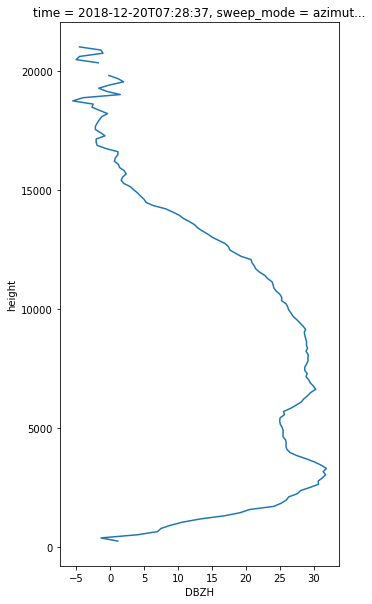

In [7]:
qvp.DBZH.plot(y='height', figsize=(5, 10))

### TimeSeries QVP

All wradlib xarray backends have the capability to read multiple sweeps/volumes in one go. We have to prepare the list of files a bit, though.

In [8]:
ts = xr.open_mfdataset(idr71, engine="odim", group="dataset1", 
                       combine="nested", concat_dim="time",
                      )

In [9]:
display(ts)

<xarray.Dataset>
Dimensions:     (time: 40, azimuth: 360, range: 200)
Coordinates:
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
  * time        (time) datetime64[ns] 2018-12-20T05:04:32 ... 2018-12-20T08:5...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 151.2
    latitude    float64 -33.7
    altitude    float64 195.0
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH          (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR         (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    PHIDP       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    SNRH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
Attributes:
    fixed_angle:  32.0

#### Georeference and add height coordinate

In [10]:
ts = ts.pipe(add_height)
display(ts)

<xarray.Dataset>
Dimensions:     (time: 40, azimuth: 360, range: 200)
Coordinates: (12/16)
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
  * time        (time) datetime64[ns] 2018-12-20T05:04:32 ... 2018-12-20T08:5...
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    y           (azimuth, range) float32 106.0 318.0 ... 4.195e+04 4.216e+04
    z           (azimuth, range) float32 262.0 395.0 ... 2.66e+04 2.673e+04
    gr          (azimuth, range) float32 106.0 318.0 ... 4.195e+04 4.216e+04
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 125.0 375.0 ... 4.962e+04 4.988e+04
    height      (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH          (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR         (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    PHIDP       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    SNRH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
Attributes:
    fixed_angle:  32.0

### Calculate Statistics and Plot QVP's

In [11]:
stats = ["median", "mean", "min", "max"]
stat = [getattr(ts.where(ts.RHOHV>0.8), st)("azimuth", skipna=True, keep_attrs=True) for st in stats]
ts_stats = xr.concat(stat, dim="stats")
ts_stats = ts_stats.assign_coords({"stats": stats})

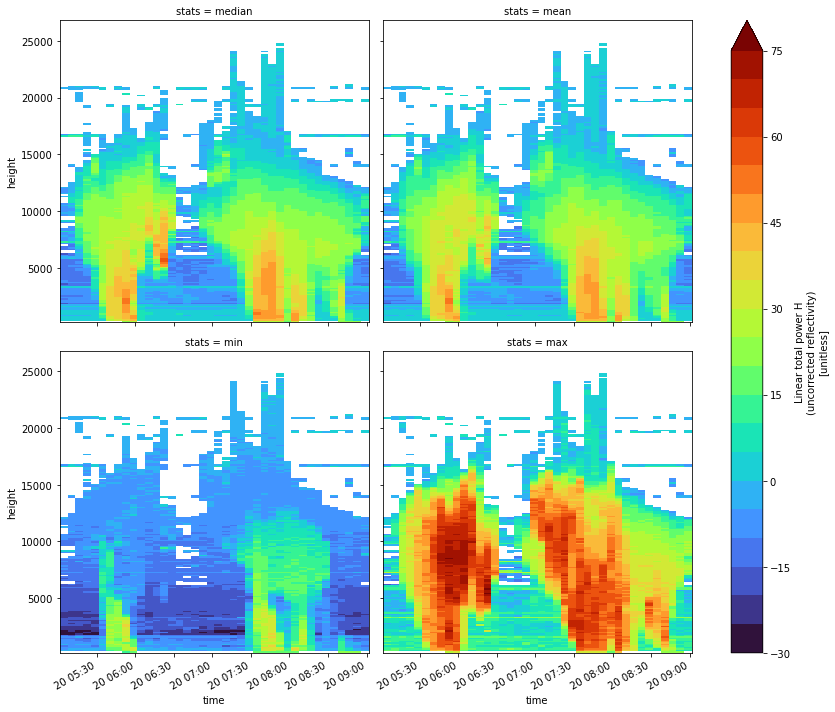

In [12]:
levels = np.arange(-30, 80, 5)
facet = ts_stats.TH.plot(x='time', y='height', col="stats", col_wrap=2, 
                           cmap="turbo", figsize=(12, 10), levels=levels)

#### Plot QVP using discrete colorbar

Text(0.5, 1.0, 'Quasi Vertical Profile - DBZH - median')

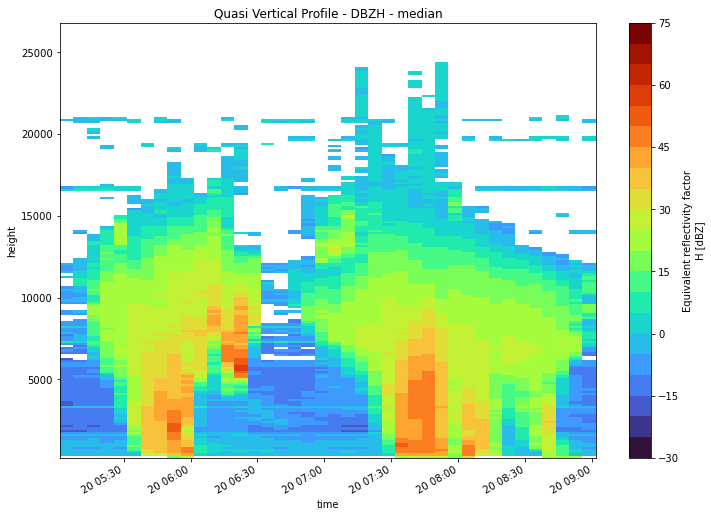

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
stat = "median"
moment = "DBZH"
ts_stats.sel(stats=stat)[moment].plot(x='time', y='height', cmap='turbo', levels=levels, ax=ax)
ax.set_title(f'Quasi Vertical Profile - {moment} - {stat}')